In [14]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True)

## 12.1 Interfacing Between pandas and Model Code
A common workflow for model development: 
- use pandas for data loading and cleaning 
- Use  modeling library (`scikit-learn`, `statsmodels`) to build the model . 
    - feature engineering: data transformation.  The data aggregation and GroupBy tools  are used often in a feature engineering context.

The point of contact between `pandas` and `other analysis libraries` is usually `NumPy` arrays. To turn a DataFrame into a NumPy array, use the `to_numpy` method:

In [3]:
data = pd.DataFrame({
    'x0': [1, 2, 3, 4, 5],
    'x1': [0.01, -0.01, 0.25, -4.1, 0.],
    'y': [-1.5, 0., 3.6, 1.3, -2.]})
data


,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [4]:
data.columns

Index(['x0', 'x1', 'y'], dtype='object')

In [5]:

data.to_numpy()  # equivalent to data.values

array([[ 1.  ,  0.01, -1.5 ],
       [ 2.  , -0.01,  0.  ],
       [ 3.  ,  0.25,  3.6 ],
       [ 4.  , -4.1 ,  1.3 ],
       [ 5.  ,  0.  , -2.  ]])

In [6]:
data.values 

array([[ 1.  ,  0.01, -1.5 ],
       [ 2.  , -0.01,  0.  ],
       [ 3.  ,  0.25,  3.6 ],
       [ 4.  , -4.1 ,  1.3 ],
       [ 5.  ,  0.  , -2.  ]])

To convert back to a DataFrame, as you may recall from earlier chapters, you can pass a two-dimensional ndarray with optional column names:

The `to_numpy` method is intended to be used when your data is homogeneous—for example, all numeric types. If you have heterogeneous data, the result will be an ndarray of Python objects:

In [48]:
df2 = pd.DataFrame(data.to_numpy(), columns=['one', 'two', 'three'])
df2

,one,two,three
0,1.0,0.01,-1.5
1,2.0,-0.01,0.0
2,3.0,0.25,3.6
3,4.0,-4.10,1.3
4,5.0,0.00,-2.0


In [7]:
df3 = data.copy() #deep copy. changes to df3 will not affect the original data
df3['strings'] = ['a', 'b', 'c', 'd', 'e']
df3

,x0,x1,y,strings
0,1,0.01,-1.5,a
1,2,-0.01,0.0,b
2,3,0.25,3.6,c
3,4,-4.10,1.3,d
4,5,0.00,-2.0,e


In [8]:
data

,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [9]:
df3.to_numpy()

array([[1, 0.01, -1.5, 'a'],
       [2, -0.01, 0.0, 'b'],
       [3, 0.25, 3.6, 'c'],
       [4, -4.1, 1.3, 'd'],
       [5, 0.0, -2.0, 'e']], dtype=object)

For some models, you may wish to use only a subset of the columns. I recommend using `loc` indexing with `to_numpy`:

In [10]:
model_cols = ['x0', 'x1']
data.loc[:, model_cols].to_numpy()

array([[ 1.  ,  0.01],
       [ 2.  , -0.01],
       [ 3.  ,  0.25],
       [ 4.  , -4.1 ],
       [ 5.  ,  0.  ]])

Some libraries have native support for pandas and do some of this work for you automatically: converting to NumPy from DataFrame and attaching model parameter names to the columns of output tables or Series. In other cases, you will have to perform this "metadata management" manually.

In [11]:
pd.Categorical(['a', 'b', 'a', 'a', 'b'])

['a', 'b', 'a', 'a', 'b']
Categories (2, object): ['a', 'b']

In [12]:
data['category'] = pd.Categorical(['a', 'b', 'a', 'a', 'b'],
                                  categories=['a', 'b']) #categories argument can be omitted here
data

,x0,x1,y,category
0,1,0.01,-1.5,a
1,2,-0.01,0.0,b
2,3,0.25,3.6,a
3,4,-4.10,1.3,a
4,5,0.00,-2.0,b


If we wanted to replace the `'category'` column with dummy variables, we create dummy variables, drop the 'category' column, and then join the result:

In [ ]:
data.category # only works when the col name contains no space 
data['category'] # more flex

In [55]:
dummies = pd.get_dummies(data.category, prefix='category', # one-hot coding
                         dtype=float)
dummies

,category_a,category_b
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [13]:
data

,x0,x1,y,category
0,1,0.01,-1.5,a
1,2,-0.01,0.0,b
2,3,0.25,3.6,a
3,4,-4.10,1.3,a
4,5,0.00,-2.0,b


In [56]:
data_with_dummies = data.drop('category', axis=1).join(dummies) #left-join by default on index. 
data_with_dummies

,x0,x1,y,category_a,category_b
0,1,0.01,-1.5,1.0,0.0
1,2,-0.01,0.0,0.0,1.0
2,3,0.25,3.6,1.0,0.0
3,4,-4.10,1.3,1.0,0.0
4,5,0.00,-2.0,0.0,1.0


There are some nuances to fitting certain statistical models with dummy variables. It may be simpler and less error-prone to use `Patsy` when you have more than simple numeric columns.

## 12.2 Creating Model Descriptions with Patsy
`Patsy` is a Python library for describing statistical models (especially linear models) with a string-based "formula syntax," which is inspired by (but not exactly the same as) the formula syntax used by the `R` and `S` statistical programming languages. It is installed automatically when you install `statsmodels`:

`conda install statsmodels`
Patsy is well supported for specifying linear models in `statsmodels`.  `Patsy`'s formulas are a special string syntax that looks like:

`y ~ x0 + x1`
The syntax `a + b` does not mean to add `a` to `b`, but rather that these are terms in the design matrix created for the model. The `patsy.dmatrices` function takes a formula string along with a dataset (which can be a DataFrame or a dictionary of arrays) and produces design matrices for a linear model:

In [15]:
data = pd.DataFrame({
    'x0': [1, 2, 3, 4, 5],
    'x1': [0.01, -0.01, 0.25, -4.1, 0.],
    'y': [-1.5, 0., 3.6, 1.3, -2.]})
data


,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [17]:
import patsy
y, X = patsy.dmatrices('y ~ x0 + x1', data)

In [18]:
y

DesignMatrix with shape (5, 1)
     y
  -1.5
   0.0
   3.6
   1.3
  -2.0
  Terms:
    'y' (column 0)

In [19]:
X

DesignMatrix with shape (5, 3)
  Intercept  x0     x1
          1   1   0.01
          1   2  -0.01
          1   3   0.25
          1   4  -4.10
          1   5   0.00
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'x1' (column 2)

These `Patsy` DesignMatrix instances are NumPy ndarrays with additional metadata:

In [20]:
np.asarray(y)

array([[-1.5],
       [ 0. ],
       [ 3.6],
       [ 1.3],
       [-2. ]])

In [21]:
np.asarray(y).shape

(5, 1)

In [22]:
np.asarray(X)

array([[ 1.  ,  1.  ,  0.01],
       [ 1.  ,  2.  , -0.01],
       [ 1.  ,  3.  ,  0.25],
       [ 1.  ,  4.  , -4.1 ],
       [ 1.  ,  5.  ,  0.  ]])

You might wonder where the `Intercept` term came from. This is a convention for linear models like ordinary least squares (OLS) regression. You can suppress the intercept by adding the term `+ 0` to the model:

In [24]:
patsy.dmatrices('y ~ x0 + x1 + 0', data)[1]

DesignMatrix with shape (5, 2)
  x0     x1
   1   0.01
   2  -0.01
   3   0.25
   4  -4.10
   5   0.00
  Terms:
    'x0' (column 0)
    'x1' (column 1)

In [25]:
patsy.dmatrices('y ~ x0 + x1 + 0', data)[0]

DesignMatrix with shape (5, 1)
     y
  -1.5
   0.0
   3.6
   1.3
  -2.0
  Terms:
    'y' (column 0)

The Patsy objects can be passed directly into algorithms like `numpy.linalg.lstsq`, which performs an ordinary least squares regression:

In [27]:
coef, resid, _, _ = np.linalg.lstsq(X, y, rcond=None)
#rcond: specify the cutoff for small singular values
#resid: RSS

The model metadata is retained in the `design_info` attribute, so you can reattach the model column names to the fitted coefficients to obtain a Series, for example:

In [28]:
coef

array([[ 0.3129],
       [-0.0791],
       [-0.2655]])

In [29]:
X.design_info

DesignInfo(['Intercept', 'x0', 'x1'],
           factor_infos={EvalFactor('x0'): FactorInfo(factor=EvalFactor('x0'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1),
                         EvalFactor('x1'): FactorInfo(factor=EvalFactor('x1'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1)},
           term_codings=OrderedDict([(Term([]),
                                      [SubtermInfo(factors=(),
                                                   contrast_matrices={},
                                                   num_columns=1)]),
                                     (Term([EvalFactor('x0')]),
                                      [SubtermInfo(factors=(EvalFactor('x0'),),
                                                   contrast_matrices={},
     

In [30]:
X.design_info.column_names

['Intercept', 'x0', 'x1']

In [68]:
coef = pd.Series(coef.squeeze(), index=X.design_info.column_names)
coef

Intercept    0.312910
x0          -0.079106
x1          -0.265464
dtype: float64

### Data Transformations in Patsy Formulas
You can mix Python code into your Patsy formulas; when evaluating the formula, the library will try to find the functions you use in the enclosing scope:

In [31]:
y, X = patsy.dmatrices('y ~ x0 + np.log(np.abs(x1) + 1)', data)
X

DesignMatrix with shape (5, 3)
  Intercept  x0  np.log(np.abs(x1) + 1)
          1   1                 0.00995
          1   2                 0.00995
          1   3                 0.22314
          1   4                 1.62924
          1   5                 0.00000
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'np.log(np.abs(x1) + 1)' (column 2)

Some commonly used variable transformations include standardizing (to mean 0 and variance 1) and centering (subtracting the mean). Patsy has built-in functions for this purpose:

In [70]:
y, X = patsy.dmatrices('y ~ standardize(x0) + center(x1)', data)
X

c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

DesignMatrix with shape (5, 3)
  Intercept  standardize(x0)  center(x1)
          1         -1.41421        0.78
          1         -0.70711        0.76
          1          0.00000        1.02
          1          0.70711       -3.33
          1          1.41421        0.77
  Terms:
    'Intercept' (column 0)
    'standardize(x0)' (column 1)
    'center(x1)' (column 2)

As part of a modeling process, you may fit a model on one dataset, then evaluate the model based on another. This might be a hold-out portion or new data that is observed later. When applying transformations like center and standardize, you should be careful when using the model to form predications based on new data. These are called **stateful transformations**, because you must use statistics like the mean or standard deviation of the original dataset when transforming a new dataset.

The `patsy.build_design_matrices` function can apply transformations to new out-of-sample data using the saved information from the original in-sample dataset:

In [71]:
new_data = pd.DataFrame({
    'x0': [6, 7, 8, 9],
    'x1': [3.1, -0.5, 0, 2.3],
    'y': [1, 2, 3, 4]})
new_data

,x0,x1,y
0,6,3.1,1
1,7,-0.5,2
2,8,0.0,3
3,9,2.3,4


In [72]:
new_X = patsy.build_design_matrices([X.design_info], new_data)
new_X

c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


[DesignMatrix with shape (4, 3)
   Intercept  standardize(x0)  center(x1)
           1          2.12132        3.87
           1          2.82843        0.27
           1          3.53553        0.77
           1          4.24264        3.07
   Terms:
     'Intercept' (column 0)
     'standardize(x0)' (column 1)
     'center(x1)' (column 2)]

Because the plus symbol (+) in the context of Patsy formulas does not mean addition, when you want to add columns from a dataset by name, you must wrap them in the special `I` function:

In [32]:
data

,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [33]:
y, X = patsy.dmatrices('y ~ I(x0 + x1)', data)
X

DesignMatrix with shape (5, 2)
  Intercept  I(x0 + x1)
          1        1.01
          1        1.99
          1        3.25
          1       -0.10
          1        5.00
  Terms:
    'Intercept' (column 0)
    'I(x0 + x1)' (column 1)

Patsy has several other built-in transforms in the `patsy.builtins` module. See the online documentation for more.

### Categorical Data and Patsy
Nonnumeric data can be transformed for a model design matrix in many different ways. When you use nonnumeric terms in a Patsy formula, they are converted to **dummy variables** by default. If there is an intercept, one of the levels will be left out to avoid collinearity:

In [34]:
data = pd.DataFrame({
    'key1': ['a', 'a', 'b', 'b', 'a', 'b', 'a', 'b'],
    'key2': [0, 1, 0, 1, 0, 1, 0, 0],
    'v1': [1, 2, 3, 4, 5, 6, 7, 8],
    'v2': [-1, 0, 2.5, -0.5, 4.0, -1.2, 0.2, -1.7]
})
data

,key1,key2,v1,v2
0,a,0,1,-1.0
1,a,1,2,0.0
2,b,0,3,2.5
3,b,1,4,-0.5
4,a,0,5,4.0
5,b,1,6,-1.2
6,a,0,7,0.2
7,b,0,8,-1.7


In [35]:
y, X = patsy.dmatrices('v2 ~ key1', data)
X

DesignMatrix with shape (8, 2)
  Intercept  key1[T.b]
          1          0
          1          0
          1          1
          1          1
          1          0
          1          1
          1          0
          1          1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)

If you omit the intercept from the model, then columns for each category value will be included in the model design matrix:

In [36]:
y, X = patsy.dmatrices('v2 ~ key1 + 0', data)
X

DesignMatrix with shape (8, 2)
  key1[a]  key1[b]
        1        0
        1        0
        0        1
        0        1
        1        0
        0        1
        1        0
        0        1
  Terms:
    'key1' (columns 0:2)

Numeric columns can be interpreted as categorical with the `C` function:

In [78]:
y, X = patsy.dmatrices('v2 ~ C(key2)', data)
X

c:\Users\Yi\anaconda3\envs\stat1010\Lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


DesignMatrix with shape (8, 2)
  Intercept  C(key2)[T.1]
          1             0
          1             1
          1             0
          1             1
          1             0
          1             1
          1             0
          1             0
  Terms:
    'Intercept' (column 0)
    'C(key2)' (column 1)

When you're using multiple categorical terms in a model, things can be more complicated, as you can include interaction terms of the form `key1:key2`, which can be used, for example, in analysis of variance (ANOVA) models:

In [37]:
data['key2'] = data['key2'].map({0: 'zero', 1: 'one'})
data

,key1,key2,v1,v2
0,a,zero,1,-1.0
1,a,one,2,0.0
2,b,zero,3,2.5
3,b,one,4,-0.5
4,a,zero,5,4.0
5,b,one,6,-1.2
6,a,zero,7,0.2
7,b,zero,8,-1.7


In [38]:
y, X = patsy.dmatrices('v2 ~ key1 + key2', data)
X

DesignMatrix with shape (8, 3)
  Intercept  key1[T.b]  key2[T.zero]
          1          0             1
          1          0             0
          1          1             1
          1          1             0
          1          0             1
          1          1             0
          1          0             1
          1          1             1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)
    'key2' (column 2)

In [39]:
y, X = patsy.dmatrices('v2 ~ key1 + key2 + key1:key2', data)
X

DesignMatrix with shape (8, 4)
  Intercept  key1[T.b]  key2[T.zero]  key1[T.b]:key2[T.zero]
          1          0             1                       0
          1          0             0                       0
          1          1             1                       1
          1          1             0                       0
          1          0             1                       0
          1          1             0                       0
          1          0             1                       0
          1          1             1                       1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)
    'key2' (column 2)
    'key1:key2' (column 3)

## 12.3 Introduction to statsmodels
`statsmodels` is a Python library for fitting many kinds of statistical models, performing statistical tests, and data exploration and visualization. statsmodels contains more "classical" frequentist statistical methods, while Bayesian methods and machine learning models are found in other libraries.

Some kinds of models found in `statsmodels` include:

Linear models, generalized linear models, and robust linear models

Linear mixed effects models

Analysis of variance (ANOVA) methods

Time series processes and state space models

Generalized method of moments

### Estimating Linear Models
There are several kinds of linear regression models in statsmodels, from the more basic (e.g., ordinary least squares) to more complex (e.g., iteratively reweighted least squares).

Linear models in statsmodels have two different main interfaces: array based and formula based. These are accessed through these API module imports:
```
import statsmodels.api as sm
import statsmodels.formula.api as smf
```

To show how to use these, we generate a linear model from some random data. Run the following code in a Jupyter cell:

In [41]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [42]:
size =1 
size = size,
size

(1,)

In [43]:
# To make the example reproducible
rng = np.random.default_rng(seed=12345)

def dnorm(mean, variance, size=1):
    if isinstance(size, int):
        size = size,   # convert to 1-D tuple 
    return mean + np.sqrt(variance) * rng.standard_normal(*size)

N = 100
X = np.c_[dnorm(0, 0.4, size=N), #np.c_: concat along the second axis; np.r_: concat along the first axis
          dnorm(0, 0.6, size=N),
          dnorm(0, 0.2, size=N)]
eps = dnorm(0, 0.1, size=N)
beta = [0.1, 0.3, 0.5]

y = np.dot(X, beta) + eps

In [44]:
X[:5], y[:5]

(array([[-0.9005, -0.1894, -1.0279],
        [ 0.7993, -1.546 , -0.3274],
        [-0.5507, -0.1203,  0.3294],
        [-0.1639,  0.824 ,  0.2083],
        [-0.0477, -0.2131, -0.0482]]),
 array([-0.5995, -0.5885,  0.1856, -0.0075, -0.0154]))

A linear model is generally fitted with an intercept term, as we saw before with Patsy. The `sm.add_constant` function can add an intercept column to an existing matrix:

In [45]:
X_model = sm.add_constant(X)
X_model[:5]

array([[ 1.    , -0.9005, -0.1894, -1.0279],
       [ 1.    ,  0.7993, -1.546 , -0.3274],
       [ 1.    , -0.5507, -0.1203,  0.3294],
       [ 1.    , -0.1639,  0.824 ,  0.2083],
       [ 1.    , -0.0477, -0.2131, -0.0482]])

In [46]:
model = sm.OLS(y, X)

In [47]:
results = model.fit()
results.params

array([0.0668, 0.268 , 0.4505])

In [48]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.452
Method:                 Least Squares   F-statistic:                              28.51
Date:                Mon, 13 Nov 2023   Prob (F-statistic):                    2.66e-13
Time:                        09:12:19   Log-Likelihood:                         -25.611
No. Observations:                 100   AIC:                                      57.22
Df Residuals:                      97   BIC:                                      65.04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The parameter names here have been given the generic names x1, x2, and so on. Suppose instead that all of the model parameters are in a DataFrame:

In [49]:
sm.OLS(y, X_model).fit().params

array([-0.0208,  0.0658,  0.269 ,  0.4494])

In [110]:
sm.OLS(y, X_model).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     28.36
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           3.23e-13
Time:                        20:36:54   Log-Likelihood:                -25.390
No. Observations:                 100   AIC:                             58.78
Df Residuals:                      96   BIC:                             69.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0208      0.032     -0.653      0.516      -0.084       0.042
x1             0.0658      0.054      1.220      0.226      -0.041       0.173
x2             0.2690      0.043      6.312      0.000       0.184       0.354
x3             0.4494      0.068      6.567      0.000       0.314       0.585
==============================================================================
Omnibus:                        0.429   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.296
Skew:                           0.133   Prob(JB):                        0.863
Kurtosis:                       2.995   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
data = pd.DataFrame(X, columns=['col0', 'col1', 'col2'])
data['y'] = y
data[:5]

,col0,col1,col2,y
0,-0.900506,-0.189430,-1.027870,-0.599527
1,0.799252,-1.545984,-0.327397,-0.588454
2,-0.550655,-0.120254,0.329359,0.185634
3,-0.163916,0.824040,0.208275,-0.007477
4,-0.047651,-0.213147,-0.048244,-0.015374


In [105]:
results = smf.ols('y ~ col0 + col1 + col2', data=data).fit() #use smf formula API, do not need an intercept term in the formula
results.params # automatically fitted an Intercept

Intercept   -0.020799
col0         0.065813
col1         0.268970
col2         0.449419
dtype: float64

In [106]:
results.tvalues # t-values

Intercept   -0.652501
col0         1.219768
col1         6.312369
col2         6.567428
dtype: float64

Observe how statsmodels has returned results as Series with the DataFrame column names attached. We also do not need to use add_constant when using formulas and pandas objects.

Given new out-of-sample data, you can compute predicted values given the estimated model parameters:

In [111]:
results.predict(data[:5])

0   -0.592959
1   -0.531160
2    0.058636
3    0.283658
4   -0.102947
dtype: float64

### Estimating Time Series Processes
Another class of models in statsmodels is for time series analysis. Among these are autoregressive processes, Kalman filtering and other state space models, and multivariate autoregressive models.

Let's simulate some time series data with an autoregressive structure and noise. 


In [112]:
init_x = 4

values = [init_x, init_x]
N = 1000

b0 = 0.8
b1 = -0.4
noise = dnorm(0, 0.1, N)
for i in range(N):
    new_x = values[-1] * b0 + values[-2] * b1 + noise[i]
    values.append(new_x)

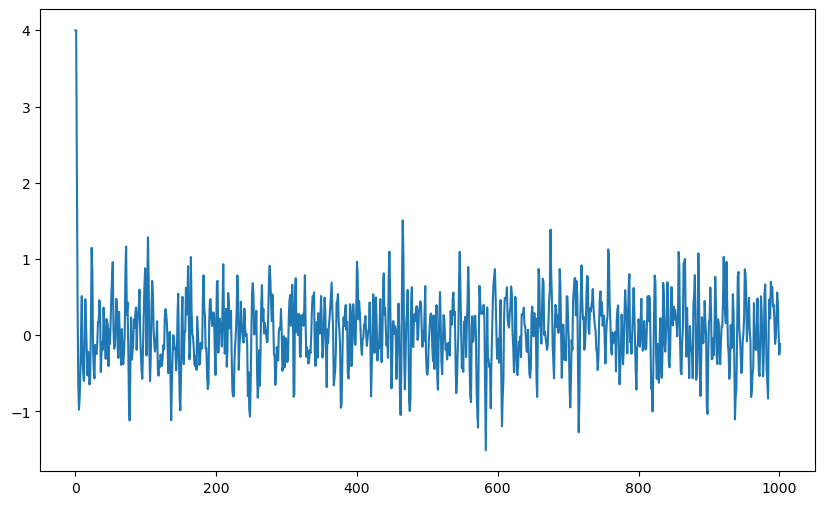

In [114]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(values)

This data has an `AR(2)` structure (two lags) with parameters 0.8 and –0.4. When you fit an AR model, you may not know the number of lagged terms to include, so you can fit the model with some larger number of lags:

In [115]:
from statsmodels.tsa.ar_model import AutoReg
MAXLAGS = 5
model = AutoReg(values, MAXLAGS)
results = model.fit()

The estimated parameters in the results have the intercept first, and the estimates for the first two lags next:

In [116]:
results.params

array([ 0.0235,  0.8097, -0.4287, -0.0334,  0.0427, -0.0567])

## 12.4 Introduction to scikit-learn
`scikit-learn` is one of the most widely used and trusted general-purpose Python machine learning toolkits. It contains a broad selection of standard **supervised** and **unsupervised** machine learning methods, with tools for model selection and evaluation, data transformation, data loading, and model persistence. These models can be used for classification, clustering, prediction, and other common tasks. You can install scikit-learn from conda like so:

`conda install scikit-learn`

 use a now-classic dataset from a Kaggle competition about passenger survival rates on the Titanic in 1912. We load the training and test datasets using pandas:

In [117]:
train = pd.read_csv('datasets/titanic/train.csv')
test = pd.read_csv('datasets/titanic/test.csv')
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [118]:
train.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [119]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In statistics and machine learning examples like this one, a typical task is to predict whether a passenger would survive based on features in the data. A model is fitted on a training dataset and then evaluated on an out-of-sample testing dataset.

use the median of the training dataset to fill the nulls in both tables:

In [120]:
impute_value = train['Age'].median()
train['Age'] = train['Age'].fillna(impute_value)
test['Age'] = test['Age'].fillna(impute_value)

Now we need to specify our models. I add a column IsFemale as an encoded version of the 'Sex' column:

In [121]:
train['IsFemale'] = (train['Sex'] == 'female').astype(int)
test['IsFemale'] = (test['Sex'] == 'female').astype(int)

Then we decide on some model variables and create NumPy arrays:

In [122]:
predictors = ['Pclass', 'IsFemale', 'Age']

X_train = train[predictors].to_numpy()
X_test = test[predictors].to_numpy()
y_train = train['Survived'].to_numpy()
X_train[:5]

array([[ 3.,  0., 22.],
       [ 1.,  1., 38.],
       [ 3.,  1., 26.],
       [ 1.,  1., 35.],
       [ 3.,  0., 35.]])

In [123]:
y_train[:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [124]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [125]:
model.fit(X_train, y_train)

LogisticRegression()

In [126]:
y_predict = model.predict(X_test)
y_predict[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

If you had the true values for the test dataset, you could compute an accuracy percentage or some other error metric:

`(y_true == y_predict).mean()`

In practice, there are often many additional layers of complexity in model training. Many models have parameters that can be tuned, and there are techniques such as cross-validation that can be used for parameter tuning to avoid overfitting to the training data. This can often yield better predictive performance or robustness on new data.

Cross-validation works by splitting the training data to simulate out-of-sample prediction. Based on a model accuracy score like mean squared error, you can perform a grid search on model parameters. Some models, like logistic regression, have estimator classes with built-in cross-validation. For example, the LogisticRegressionCV class can be used with a parameter indicating how fine-grained of a grid search to do on the model regularization parameter `C`:

In [127]:
from sklearn.linear_model import LogisticRegressionCV
model_cv = LogisticRegressionCV(Cs=10) # 10 values in the log scale between 1e-4, 1e4. C=inverse of the regularization.
model_cv.fit(X_train, y_train)

LogisticRegressionCV()

To do cross-validation by hand, you can use the `cross_val_score` helper function, which handles the data splitting process. For example, to cross-validate our model with four nonoverlapping splits of the training data, we can do:

In [128]:
from sklearn.model_selection import cross_val_score
model = LogisticRegression(C=10)
scores = cross_val_score(model, X_train, y_train, cv=4)
scores

array([0.7758, 0.7982, 0.7758, 0.7883])

In [46]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS